In [1]:
# %reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl
import pickle as pk
import scipy.interpolate as interp

%load_ext autoreload
%autoreload 2

import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)



/tmp/ipykernel_2814228/1829470593.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.5

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -5.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 14.5, 48
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [3]:
z_array_fit = np.array([0.001, 0.5, 1.0])
snap_num_fit = np.array([32, 28, 26])
lgM_bin_min = jnp.array([13.0, 13.5, 14.0])
lgM_bin_max = jnp.array([13.5, 14.0, 14.5])
lgM_bin_mean = 0.5*(lgM_bin_min + lgM_bin_max)

# df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps_lite.pkl', 'rb'))
df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps.pkl', 'rb'))



In [4]:
all_sims_names = list(df_all_data.keys())
print(len(all_sims_names))


200


In [5]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import mass_function
import scipy.interpolate as interpolate

cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)

# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
# from jax_cosmo.scipy.interpolate import interp
import scipy.interpolate as interp
from jax import grad
from jax import vmap
from jax import value_and_grad

from jaxopt import ScipyBoundedMinimize
from jaxopt import LBFGSB



# params_vary_names = ['n_nt', 'alpha_nt', 'theta_ej_0', 'log10_Mstar0_theta_ej', 'nu_theta_ej_M', 'theta_co_0', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'gamma_rhogas', 'delta_rhogas', 'mu_beta', 'eta_star', 'eta_cga']
# lower_bounds = jnp.array([0.0001, -3.0, 0.00001, -8.0, -8.0, -8.0, 10.0, 0.01, 0.01, -1.0, 0.05, 0.3])
# upper_bounds = jnp.array([8.0, 3.0, 0.8, 3.0, 3.0, 3.0, 17.0, 8.0, 15.0, 0.8, 8.0, 5.0])
lower_bounds_dict = {'n_nt':0.0001, 'alpha_nt':0.01 , 'log10_Mstar0_theta_ej':11.0, 'theta_ej_0': 0.5, 'nu_theta_ej_M': -5.0, 'theta_co_0': 1e-12, 'nu_theta_co_M': -8.0, 'nu_theta_ej_z': -8.0, 'nu_z': -8.0, 'log10_Mc0': 10.0, 'gamma_rhogas': 0.2, 'delta_rhogas': 0.01, 'mu_beta': 0.0, 'eta_star': 0.001, 'eta_cga': 0.01}
upper_bounds_dict = {'n_nt':0.7,'alpha_nt':0.5 , 'log10_Mstar0_theta_ej':15.0,'theta_ej_0': 8.0, 'nu_theta_ej_M': 0.0, 'theta_co_0': 0.8, 'nu_theta_co_M': 3.0, 'nu_theta_ej_z': 5.0, 'nu_z': 8.0, 'log10_Mc0': 16.5, 'gamma_rhogas': 6.0, 'delta_rhogas': 15.0, 'mu_beta': 5.0, 'eta_star': 0.6, 'eta_cga': 1.0}


# params_vary_names = ['n_nt', 'theta_ej_0', 'nu_theta_ej_M', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'theta_co_0', 'gamma_rhogas']
# params_vary_names = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'mu_beta', 'delta_rhogas', 'gamma_rhogas']

# params_vary_names = ['theta_ej_0', 'theta_co_0', 'gamma_rhogas','mu_beta','eta_star','alpha_nt', 'log10_Mc0','nu_theta_ej_M']
params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']
# params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
# params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','nu_theta_ej_M','eta_star','alpha_nt']



/mnt/home/spandey/venv_gm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
mean_err_all = []
mean_err_all_indiv_array = []
mean_err_sigma_all = []
mean_err_sigma_all_indiv_array = []
saved_plot_data_all = {}
for jsim in range(len(all_sims_names)):
    saved_load = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_FINALSET_windiv_error.pkl', 'rb'))
    if all_sims_names[jsim] not in saved_load.keys():
    # for jsnap in range(len(snap_num_fit)):

        # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_32.pkl','rb'))
        # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_32.pkl','rb'))
        # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profs_highT.pk','rb'))
        # print(df_at.keys())
        df_at = df_all_data[all_sims_names[jsim]][snap_num_fit[0]]

        dg_val = 3
        x_array_data_all = df_at['r_r200c'][::dg_val]

        xmin, xmax = 0.05, 1.0
        indselx = np.where((x_array_data_all > xmin) & (x_array_data_all < xmax))[0]
        x_array_data = x_array_data_all[indselx]

        # lgmass_all = df_at['lgmass_all']
        rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
        ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
        Pe_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

        sig_rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
        sig_ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
        sig_Pe_gas_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

        for jz in range(len(z_array_fit)):
            snap_num_jz = snap_num_fit[jz]
            # print('snap_num_jz = ' + str(snap_num_jz))
            # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))
            # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
            df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
            M_dmo_all = df_at['M_dmo']
            rho_dmb_all = df_at['rho_dmb_all']
            # rho_gas_all = df_at['rho_gas_all']
            ne_all = df_at['ne_all']    
            Pe_all = df_at['P_all']
            lgM_dmo_all = np.log10(M_dmo_all)
            for jM in range(len(lgM_bin_min)):
                indselM = np.where((lgM_dmo_all > lgM_bin_min[jM]) & (lgM_dmo_all < lgM_bin_max[jM]))[0]
                # print(indselM.shape)

                rho_dmb_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
                ne_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
                Pe_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
                for jbM in range(len(indselM)):
                    rho_dmb_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(rho_dmb_all[indselM[jbM],:]))
                    rho_dmb_dv_all_jM[jbM, :] = np.exp(rho_dmb_interp(np.log(x_array_data)))

                    ne_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(ne_all[indselM[jbM],:]))
                    ne_dv_all_jM[jbM, :] = np.exp(ne_interp(np.log(x_array_data)))

                    Pe_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(Pe_all[indselM[jbM],:]))
                    Pe_dv_all_jM[jbM, :] = np.exp(Pe_interp(np.log(x_array_data)))
                


                rho_dmb_dv[jz, jM, :] = np.mean(rho_dmb_dv_all_jM, axis=0)
                ne_dv[jz, jM, :] = np.mean(ne_dv_all_jM, axis=0)
                Pe_dv[jz, jM, :] = np.mean(Pe_dv_all_jM, axis=0)

                sig_rho_dmb_dv[jz, jM, :] = np.std(rho_dmb_dv_all_jM, axis=0)
                sig_ne_dv[jz, jM, :] = np.std(ne_dv_all_jM, axis=0)
                sig_Pe_gas_dv[jz, jM, :] = np.std(Pe_dv_all_jM, axis=0)


        dmb_dv_flatten_sims = rho_dmb_dv.flatten()
        gas_dv_flatten_sims = ne_dv.flatten()
        Pgas_dv_flatten_sims = Pe_dv.flatten()
        sig_dmb_dv_flatten_sims = sig_rho_dmb_dv.flatten()
        sig_gas_dv_flatten_sims = sig_ne_dv.flatten()
        sig_Pgas_dv_flatten_sims = sig_Pe_gas_dv.flatten()

        dv_combined = jnp.concatenate((dmb_dv_flatten_sims, gas_dv_flatten_sims, Pgas_dv_flatten_sims))
        ind_finite = jnp.where(jnp.isfinite(dv_combined))[0]
        dv_combined = dv_combined[ind_finite]
        # sigma_value_combined = 0.05*dv_combined
        sigma_value_combined = jnp.concatenate((sig_dmb_dv_flatten_sims, sig_gas_dv_flatten_sims, sig_Pgas_dv_flatten_sims))
        sigma_value_combined = sigma_value_combined[ind_finite]
        # sigma_value_combined = 0.05*dv_combined
        cov_combined = jnp.diag(sigma_value_combined**2)
        # precision_combined = jnp.linalg.inv(cov_combined)
        precision_combined = jnp.diag(1./sigma_value_combined**2)

        # from get_BCMP_profile_jit import BCM_18_wP
        BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)
        rho_dmb = BCMP_test.rho_dmb_mat_physical
        # # rho_gas = BCMP_test.rho_gas_mat_physical
        ne_gas = BCMP_test.ne_mat_physical
        Pe_gas = BCMP_test.Pe_mat_physical


        masks_all = np.zeros(( len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
        dndlnM_jb_repeat_all = np.zeros((len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
        norm_value_all = np.zeros((len(z_array_fit),len(lgM_bin_min)))


        for jz in range(len(z_array_fit)):
            zmean = z_array_fit[jz]

            cmean_array = concentration.concentration(10**lgM_bin_mean, '200c', zmean, model = 'diemer19')
            cmean_array = jnp.array(cmean_array)

            lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
            M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)
            # dndlnM_th = mass_function.massFunction(M200c_array, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')
            # dndlnM_th = jnp.array(dndlnM_th)
            snap_num_jz = snap_num_fit[jz]    
            # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
            df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
            M_dmo_all = df_at['M_dmo']
            zmean = z_array_fit[0]
            # len(M_dmo_all)
            # vol = 100**3
            lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
            M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)

            lg10Mbins_all = np.linspace(12.8, 15.0, 18)
            # lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
            lg10Mbins_cent = 0.5*(lg10Mbins_all[1:] + lg10Mbins_all[:-1])

            hist_dmo = np.histogram(np.log10(M_dmo_all), bins=lg10Mbins_all)
            # get dn/dlnM from this histogram:
            vol = 100**3
            n_hist = hist_dmo[0]/vol
            n_hist = n_hist/np.diff(lg10Mbins_all)
            n_hist = n_hist/np.log(10)

            f_nhist = interpolate.interp1d(np.log(10**lg10Mbins_cent), np.log(n_hist + 1e-20), kind='cubic')

            dndlnM_th = jnp.exp(jnp.array(f_nhist(np.log(M200c_array))))

            # dndlnM_jb_repeat_all = {}
            for jb in range(len(lgM_bin_min)):
                lgM_min_jb = lgM_bin_min[jb]
                lgM_max_jb = lgM_bin_max[jb]
                cmean_jb = cmean_array[jb]
                c_array_th = jnp.exp(jnp.linspace(jnp.log(halo_params_dict['cmin']), jnp.log(halo_params_dict['cmax']), halo_params_dict['nc']))
                indc = jnp.argmin(jnp.abs(c_array_th - cmean_jb))
                # print(indc, cmean_jb)
                # lgM_array_th = jnp.log10(jnp.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']))
                M_array_th = BCMP_test.M_array
                # M_array_th = np.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'])
                # M_array_th = BCMP_test.Mdmb_r200_mat[indc, 0, :]
                lgM_array_th = jnp.log10(M_array_th)
                indM_min = jnp.argmin(jnp.abs(lgM_array_th - lgM_min_jb))
                indM_max = jnp.argmin(jnp.abs(lgM_array_th - lgM_max_jb))
                # mask = jnp.zeros((halo_params_dict['nr'], halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
                # mask = jax.ops.index_update(mask, jax.ops.index[:, indc, 0, indM_min:indM_max+1], 1)
                # mask = mask.at[:, indc, 0, indM_min:indM_max+1].set(1)
                masks_all[jz, jb,:, indc, jz, indM_min:indM_max+1] = 1
                # print(jz, jb, indc, jz, indM_min,indM_max+1)
                dndlnM_jb_repeat = jnp.tile(dndlnM_th.reshape(1,1,1,masks_all.shape[-1]), (masks_all.shape[-4],masks_all.shape[-3],masks_all.shape[-2], 1))
                # dndlnM_jb_repeat *= mask
                # dndlnM_jb_repeat_all[jb] = dndlnM_jb_repeat
                norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])
                norm_value_all[jz,jb] = norm_value
                # print(norm_value)
                dndlnM_jb_repeat_all[jz,jb,...] = dndlnM_jb_repeat * masks_all[jz,jb,...]

        masks_all = jnp.array(masks_all.astype(int))
        dndlnM_jb_repeat_all = jnp.array(dndlnM_jb_repeat_all)
        norm_value_all = jnp.array(norm_value_all)


        def get_value(x):        
            sim_params_dict_vary = copy.deepcopy(sim_params_dict)
            for jp in range(len(params_vary_names)):
                sim_params_dict_vary[params_vary_names[jp]] = x[jp]

            
            # Now that params are defined, here is the forward model
            # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
            BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
            # theory = BCMP_test_vary.rho_dmb_mat

            rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
            # rho_gas = BCMP_test_vary.rho_gas_mat_physical
            ne_gas = BCMP_test_vary.ne_mat_physical    
            Pe_gas = BCMP_test_vary.Pe_mat_physical
            
            def interp_rho_dmb(jc, jz, jM):
                rho_dmb_here = rho_dmb[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            def interp_rho_gas(jc, jz, jM):
                rho_dmb_here = ne_gas[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            def interp_Pe_gas(jc, jz, jM):
                rho_dmb_here = Pe_gas[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


            vmap_func1 = vmap(interp_rho_gas, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


            vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

            def get_mean_rhodmb(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                rho_dmb_rM = rhodmb_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
                rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
                return rho_dmb_mean

            def get_mean_rhogas(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                rho_gas_rM = rhogas_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
                rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
                return rho_gas_mean

            def get_mean_Pe(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                Pe_gas_rM = Pe_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                Pth_mean = jnp.sum(Pth_mean, axis=-1)
                Pth_mean = jnp.sum(Pth_mean, axis=-1)
                return Pth_mean


            vmap_func1 = vmap(get_mean_rhodmb, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

            vmap_func1 = vmap(get_mean_rhogas, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

            vmap_func1 = vmap(get_mean_Pe, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

            dmb_dv_flatten = rho_dmb_dv_th.flatten()
            gas_dv_flatten = rho_gas_dv_th.flatten()
            Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

            theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
            # theory_combined = jnp.log(theory_combined)
            chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
            # print(chi2)

            return chi2


        def get_model(x):

            sim_params_dict_vary = copy.deepcopy(sim_params_dict)
            
            for jp in range(len(params_vary_names)):
                sim_params_dict_vary[params_vary_names[jp]] = x[jp]

            
            # Now that params are defined, here is the forward model
            # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
            BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
            # theory = BCMP_test_vary.rho_dmb_mat

            rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
            # rho_gas = BCMP_test_vary.rho_gas_mat_physical
            ne_gas = BCMP_test_vary.ne_mat_physical    
            Pe_gas = BCMP_test_vary.Pe_mat_physical
            
            def interp_rho_dmb(jc, jz, jM):
                rho_dmb_here = rho_dmb[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            def interp_rho_gas(jc, jz, jM):
                rho_dmb_here = ne_gas[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            def interp_Pe_gas(jc, jz, jM):
                rho_dmb_here = Pe_gas[:,jc, jz, jM]
                r_theory = BCMP_test.r_array
                r200_here = BCMP_test.r200c_mat[jM, jz]
                val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
                return val_out

            vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


            vmap_func1 = vmap(interp_rho_gas, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


            vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
            vmap_func2 = vmap(vmap_func1, (None, 0, None))
            vmap_func3 = vmap(vmap_func2, (None, None, 0))
            Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

            def get_mean_rhodmb(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                rho_dmb_rM = rhodmb_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
                rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
                return rho_dmb_mean

            def get_mean_rhogas(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                rho_gas_rM = rhogas_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
                rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
                return rho_gas_mean

            def get_mean_Pe(jbz,jbM):
                lgM_array_th = jnp.log10(BCMP_test.M_array)
                M_array_th = 10**lgM_array_th
                mask = masks_all[jbz, jbM]
                # apply mask:
                Pe_gas_rM = Pe_xbins_interp * mask
                dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
                Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
                Pth_mean = jnp.sum(Pth_mean, axis=-1)
                Pth_mean = jnp.sum(Pth_mean, axis=-1)
                return Pth_mean


            vmap_func1 = vmap(get_mean_rhodmb, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

            vmap_func1 = vmap(get_mean_rhogas, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

            vmap_func1 = vmap(get_mean_Pe, (0, None))
            vmap_func2 = vmap(vmap_func1, (None, 0))
            Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
            Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

            dmb_dv_flatten = rho_dmb_dv_th.flatten()
            gas_dv_flatten = rho_gas_dv_th.flatten()
            Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

            theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
            # theory_combined = jnp.log(theory_combined)
            chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
            # print(chi2)
            mean_err = np.mean(np.abs((theory_combined - dv_combined)/theory_combined))
            mean_err_sigma = np.mean(np.abs((theory_combined - dv_combined)/sigma_value_combined)) 

            chi2_dmb = jnp.sqrt(jnp.sum((dmb_dv_flatten - dmb_dv_flatten_sims)**2 / sig_dmb_dv_flatten_sims**2))
            chi2_gas = jnp.sqrt(jnp.sum((gas_dv_flatten - gas_dv_flatten_sims)**2 / sig_gas_dv_flatten_sims**2))
            chi2_Pgas = jnp.sqrt(jnp.sum((Pe_gas_dv_th_flatten - Pgas_dv_flatten_sims)**2 / sig_Pgas_dv_flatten_sims**2))

            ind_finite_dmb = jnp.where(jnp.isfinite(dmb_dv_flatten_sims))[0]
            ind_finite_gas = jnp.where(jnp.isfinite(gas_dv_flatten_sims))[0]
            ind_finite_Pgas = jnp.where(jnp.isfinite(Pgas_dv_flatten_sims))[0]

            mean_err_dmb = np.mean(np.abs((dmb_dv_flatten - dmb_dv_flatten_sims)/dmb_dv_flatten_sims)[ind_finite_dmb])
            mean_err_gas = np.mean(np.abs((gas_dv_flatten - gas_dv_flatten_sims)/gas_dv_flatten_sims)[ind_finite_gas])
            mean_err_Pgas = np.mean(np.abs((Pe_gas_dv_th_flatten - Pgas_dv_flatten_sims)/Pgas_dv_flatten_sims)[ind_finite_Pgas])
            mean_err_all_array = np.array([mean_err_dmb, mean_err_gas, mean_err_Pgas])

            mean_err_sigma_dmb = np.mean(np.abs((dmb_dv_flatten - dmb_dv_flatten_sims)/sig_dmb_dv_flatten_sims)[ind_finite_dmb])
            mean_err_sigma_gas = np.mean(np.abs((gas_dv_flatten - gas_dv_flatten_sims)/sig_gas_dv_flatten_sims)[ind_finite_gas])
            mean_err_sigma_Pgas = np.mean(np.abs((Pe_gas_dv_th_flatten - Pgas_dv_flatten_sims)/sig_Pgas_dv_flatten_sims)[ind_finite_Pgas])
            mean_err_sigma_all_array = np.array([mean_err_sigma_dmb, mean_err_sigma_gas, mean_err_sigma_Pgas])

            return rho_dmb_dv_th, rho_gas_dv_th, Pe_gas_dv_th, theory_combined, chi2, mean_err, mean_err_sigma, mean_err_all_array, mean_err_sigma_all_array




        lbfgsb = ScipyBoundedMinimize(fun=value_and_grad(get_value), value_and_grad=True, method="l-bfgs-b", tol=1e-9, maxiter=100)

        lower_bounds = []
        upper_bounds = []
        for jp in range(len(params_vary_names)):
            lower_bounds.append(lower_bounds_dict[params_vary_names[jp]])
            upper_bounds.append(upper_bounds_dict[params_vary_names[jp]])

        lower_bounds = jnp.array(lower_bounds)
        upper_bounds = jnp.array(upper_bounds)

        bounds = (lower_bounds, upper_bounds)

        w_init = []
        for jp in range(len(params_vary_names)):
            w_init.append(sim_params_dict[params_vary_names[jp]])
        w_init = jnp.array(w_init)

        # create a random init vector within the bounds:
        # w_init = np.random.uniform(lower_bounds, upper_bounds)
        # w_init = jnp.array(w_init)


        res = lbfgsb.run(w_init, bounds=bounds)
        # lbfgs_sol = lbfgsb.params

        # res.
        params, state = res
        # print(params, state)

        rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined, chi2, mean_err, mean_err_sigma, mean_err_all_array, mean_err_sigma_all_array = get_model(params)
        print(jsim, all_sims_names[jsim],params, chi2, mean_err, mean_err_sigma, mean_err_all_array, mean_err_sigma_all_array)

        saved_plot_data_all[all_sims_names[jsim]] = {}
        saved_plot_data_all[all_sims_names[jsim]]['rho_dmb_dv_th_bf'] = rho_dmb_dv_th_bf
        saved_plot_data_all[all_sims_names[jsim]]['rho_dmb_dv'] = rho_dmb_dv
        saved_plot_data_all[all_sims_names[jsim]]['rho_gas_dv_th_bf'] = rho_gas_dv_th_bf
        saved_plot_data_all[all_sims_names[jsim]]['ne_dv'] = ne_dv
        saved_plot_data_all[all_sims_names[jsim]]['Pth_gas_dv_th_bf'] = Pth_gas_dv_th_bf
        saved_plot_data_all[all_sims_names[jsim]]['Pe_dv'] = Pe_dv
        saved_plot_data_all[all_sims_names[jsim]]['theory_combined'] = theory_combined
        saved_plot_data_all[all_sims_names[jsim]]['params_bestfit'] = params    
        saved_plot_data_all[all_sims_names[jsim]]['params_vary_names'] = params_vary_names
        saved_plot_data_all[all_sims_names[jsim]]['chi2'] = chi2
        saved_plot_data_all[all_sims_names[jsim]]['mean_err'] = mean_err
        saved_plot_data_all[all_sims_names[jsim]]['mean_err_sigma'] = mean_err_sigma
        saved_plot_data_all[all_sims_names[jsim]]['mean_err_all_array'] = mean_err_all_array
        saved_plot_data_all[all_sims_names[jsim]]['mean_err_sigma_all_array'] = mean_err_sigma_all_array

        # if np.mod(jsim, 5) == 0:
        pk.dump(saved_plot_data_all, open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_FINALSET_windiv_error.pkl','wb'))


        mean_err_all.append(mean_err)
        mean_err_sigma_all.append(mean_err_sigma)
        mean_err_all_indiv_array.append(mean_err_all_array)
        mean_err_sigma_all_indiv_array.append(mean_err_sigma_all_array)

    # pl.figure()
    # fig, axes = pl.subplots(3, 3, figsize=(17, 17), sharex=True, sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    # z_array_fit_plot = np.array([0.0, 0.5, 1.0])
    # for jp in range(3):
    #     for jz in range(3):
    #         indz = jz
    #         ax = axes[jp, jz]
    #         if jp == 0:
    #             ax.errorbar(0.97*x_array_data, rho_dmb_dv[indz,0,:], sig_rho_dmb_dv[indz,0,:],ls='', marker='s' , color='b', label=r'$13.0 < \log_{10}(M) < 13.5$')
    #             ax.errorbar(0.97*x_array_data, rho_dmb_dv_th_bf[indz,0,:],ls='--' , color='b' )

    #             ax.errorbar(x_array_data, rho_dmb_dv[indz,1,:], sig_rho_dmb_dv[indz,1,:],ls='', marker='s', color='orange', label=r'$13.5 < \log_{10}(M) < 14.0$')
    #             ax.errorbar(x_array_data, rho_dmb_dv_th_bf[indz,1,:],ls='--', color='orange' )

    #             ax.errorbar(1.03*x_array_data, rho_dmb_dv[indz,2,:], sig_rho_dmb_dv[indz,2,:],ls='', marker='s', color='r', label=r'$14.0 < \log_{10}(M) < 14.5$')
    #             ax.errorbar(1.03*x_array_data, rho_dmb_dv_th_bf[indz,2,:],ls='--', color='r' )


    #             ax.set_xscale('log')
    #             ax.set_yscale('log')
    #             # change the size of the ticklabels:
    #             ax.tick_params(axis='both', which='major', labelsize=14)
    #             ax.tick_params(axis='both', which='minor', labelsize=14)
    #             # add text:
    #             ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14, verticalalignment='top',
    #                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #             if jp == 2:
    #                 ax.set_xlabel(r'$r/r_{200c}$', size=16)
    #             if jz == 0:
    #                 ax.legend(fontsize=14, frameon=False)                
    #                 ax.set_ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=16)
    #                 ax.set_ylim(2e13, 1.4e16)

    #         if jp == 1:
    #             ax.errorbar(0.97*x_array_data, ne_dv[indz,0,:], sig_ne_dv[indz,0,:],ls='', marker='s' , color='b', label='Total mass, sims')
    #             ax.errorbar(0.97*x_array_data, rho_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

    #             ax.errorbar(x_array_data, ne_dv[indz,1,:], sig_ne_dv[indz,1,:],ls='', marker='s', color='orange', label='Gas mass, sims')
    #             ax.errorbar(x_array_data, rho_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

    #             ax.errorbar(1.03*x_array_data, ne_dv[indz,2,:], sig_ne_dv[indz,2,:],ls='', marker='s', color='r', label='Gas mass, sims')
    #             ax.errorbar(1.03*x_array_data, rho_gas_dv_th_bf[indz,2,:],ls='--', color='r' )

    #             ax.set_xscale('log')
    #             ax.set_yscale('log')
    #             ax.tick_params(axis='both', which='major', labelsize=14)
    #             ax.tick_params(axis='both', which='minor', labelsize=14)            
    #             ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14,verticalalignment='top',
    #                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #             if jp == 2:
    #                 ax.set_xlabel(r'$r/r_{200c}$', size=16)
    #             if jz == 0:
    #                 ax.set_ylabel(r'$n_e$ (${\rm cm}^3$)', size=16)

    #         if jp == 2:
    #             ax.errorbar(0.97*x_array_data, Pe_dv[indz,0,:], sig_Pe_gas_dv[indz,0,:],ls='', marker='s' , color='b', label='Total mass, sims')
    #             ax.errorbar(0.97*x_array_data, Pth_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

    #             ax.errorbar(x_array_data, Pe_dv[indz,1,:], sig_Pe_gas_dv[indz,1,:],ls='', marker='s', color='orange', label='Gas mass, sims')
    #             ax.errorbar(x_array_data, Pth_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

    #             ax.errorbar(1.03*x_array_data, Pe_dv[indz,2,:], sig_Pe_gas_dv[indz,2,:],ls='', marker='s', color='r', label='Gas mass, sims')
    #             ax.errorbar(1.03*x_array_data, Pth_gas_dv_th_bf[indz,2,:],ls='--', color='r' )
    #             ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14, verticalalignment='top',
    #                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #             ax.set_xscale('log')
    #             ax.set_yscale('log')
    #             ax.tick_params(axis='both', which='major', labelsize=14)
    #             ax.tick_params(axis='both', which='minor', labelsize=14)            
    #             if jp == 2:
    #                 ax.set_xlabel(r'$r/r_{200c}$', size=16)
    #             if jz == 0:
    #                 ax.set_ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=16)


    # pl.tight_layout()
    # pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/FIT_ANTILES_FINALSET/BCMP_18_wP_fit_sim_' + str(jsim) + '_' + str(all_sims_names[jsim]) + '.pdf',bbox_inches='tight')
    # pl.close(fig)










31 ws_324_23_mu_7_05_dT_8_35_n_9_BH_DensTh_m_2_54 [ 2.55677201  0.11468058 -5.11957306  0.3286928   2.03623641  0.
 13.97769176  0.07866033  0.15922946 -0.05319246] 4.999748017488 0.09998315691286498 0.324475129078495 [0.06537202 0.10532851 0.15446899] [0.364829   0.28471393 0.31235277]
32 ws_213_64_mu_8_09_dT_7_79_n_22_BH_DensTh_m_1_87 [ 3.21152085e+00  7.28291291e-02 -4.16012010e+00  2.50875755e-01
  1.80303051e+00  6.82718195e-04  1.00000000e+01  1.24501808e-01
  8.22841482e-02  0.00000000e+00] 5.116621550117889 0.09136893936392936 0.30699627220743436 [0.05799498 0.1038308  0.1165235 ] [0.33351152 0.30576057 0.27610773]
33 ws_207_58_mu_1_73_dT_7_33_n_27_BH_DensTh_m_2_86 [ 3.37541657  0.0323626  -5.1798519  -0.57206762  4.8087285   0.07816998
 14.22066721  0.36869041  0.13407373  0.        ] 18.103016226395223 0.49515094306576884 0.9013115899601996 [0.07785863 0.34856227 0.31926264] [0.49250181 1.42925777 0.84163843]
34 ws_350_00_mu_6_27_dT_7_24_n_13_BH_DensTh_m_2_29 [ 8.          0.

2024-01-27 00:49:00.701088: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 54.83GiB (rounded to 58877045760)requested by op 
2024-01-27 00:49:00.702755: W external/tsl/tsl/framework/bfc_allocator.cc:497] *******___________________________________________________________________________________________**
2024-01-27 00:49:00.704024: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 58877045744 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:        80B
              constant allocation:    3.33MiB
        maybe_live_out allocation:       104B
     preallocated temp allocation:   54.83GiB
  preallocated temp fragmentation:       464B (0.00%)
                 total allocation:   54.84GiB
Peak buffers:
	Buffer 1:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 58877045744 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:        80B
              constant allocation:    3.33MiB
        maybe_live_out allocation:       104B
     preallocated temp allocation:   54.83GiB
  preallocated temp fragmentation:       464B (0.00%)
                 total allocation:   54.84GiB
Peak buffers:
	Buffer 1:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 2:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 3:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 4:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 5:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 6:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 7:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 8:
		Size: 6.75GiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/transpose(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[48,3,24,128,32,64]
		==========================

	Buffer 9:
		Size: 288.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/exp" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=382
		XLA Label: fusion
		Shape: f64[48,3,128,32,64]
		==========================

	Buffer 10:
		Size: 216.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/transpose(jvp(vmap(vmap(vmap(vmap(jit(get_Mdmb)))))))/vmap(jit(get_rho_dmb))/jit(get_rho_gas_normed)/neg" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=449
		XLA Label: fusion
		Shape: f64[48,3,24,128,64]
		==========================

	Buffer 11:
		Size: 216.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/transpose(jvp(vmap(vmap(vmap(vmap(jit(get_Ptot)))))))/mul" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=558
		XLA Label: fusion
		Shape: f64[48,3,24,128,64]
		==========================

	Buffer 12:
		Size: 108.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/transpose(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/reduce_sum[axes=(4,)]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=481
		XLA Label: fusion
		Shape: f64[48,3,24,128,32]
		==========================

	Buffer 13:
		Size: 9.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_Ptot))))))/jit(_interp)/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=558
		XLA Label: fusion
		Shape: f64[48,3,128,64]
		==========================

	Buffer 14:
		Size: 9.00MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/jvp(vmap(vmap(vmap(vmap(jit(get_zeta))))))/jit(get_Mnfw)/vmap(jit(get_rho_nfw_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=349
		XLA Label: fusion
		Shape: f64[48,3,128,64]
		==========================

	Buffer 15:
		Size: 3.38MiB
		Operator: op_name="jit(value_and_grad_without_aux)/jit(main)/transpose(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/reduce_sum[axes=(4,)]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=481
		XLA Label: fusion
		Shape: f64[48,3,24,128]
		==========================



In [7]:
len(list(saved_plot_data_all.keys()))




200

In [6]:
# saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams.pkl','rb'))
saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_FINALSET_windiv_error.pkl','rb'))
mean_err_all = []
mean_err_sigma_all = []
keys_all = []
params_all = np.zeros((len(saved_plot_data_all.keys()), len(saved_plot_data_all[all_sims_names[0]]['params_bestfit'])))
for jsim in range(len(all_sims_names)):
    try:
        mean_err = saved_plot_data_all[all_sims_names[jsim]]['mean_err']
        mean_err_sigma = saved_plot_data_all[all_sims_names[jsim]]['mean_err_sigma']
        keys_all.append(all_sims_names[jsim])
        mean_err_all.append(mean_err)
        mean_err_sigma_all.append(mean_err_sigma)
        params_all[jsim,:] = saved_plot_data_all[all_sims_names[jsim]]['params_bestfit']
    except:
        pass

all_sims_names = keys_all


KeyError: 'ws_96_84_mu_7_76_dT_7_71_n_24_BH_DensTh_m_2_76'

In [7]:
# len(keys_all)
# saved_plot_data_all.keys()

dict_keys(['ws_324_23_mu_7_05_dT_8_35_n_9_BH_DensTh_m_2_54', 'ws_213_64_mu_8_09_dT_7_79_n_22_BH_DensTh_m_1_87', 'ws_207_58_mu_1_73_dT_7_33_n_27_BH_DensTh_m_2_86', 'ws_350_00_mu_6_27_dT_7_24_n_13_BH_DensTh_m_2_29', 'ws_85_62_mu_1_38_dT_8_35_n_11_BH_DensTh_m_1_70', 'ws_73_41_mu_3_15_dT_7_72_n_9_BH_DensTh_m_2_89', 'ws_210_32_mu_3_11_dT_7_20_n_29_BH_DensTh_m_2_45', 'ws_290_51_mu_8_32_dT_8_34_n_18_BH_DensTh_m_2_79', 'ws_106_66_mu_5_70_dT_7_49_n_3_BH_DensTh_m_1_53', 'ws_338_84_mu_5_34_dT_7_29_n_7_BH_DensTh_m_2_82', 'ws_316_67_mu_7_55_dT_7_89_n_7_BH_DensTh_m_1_79', 'ws_215_78_mu_2_07_dT_8_01_n_3_BH_DensTh_m_2_87', 'ws_140_80_mu_4_77_dT_7_18_n_16_BH_DensTh_m_2_81', 'ws_77_27_mu_6_09_dT_7_92_n_17_BH_DensTh_m_1_08', 'ws_104_55_mu_2_36_dT_7_38_n_3_BH_DensTh_m_1_42', 'ws_296_56_mu_4_87_dT_7_37_n_5_BH_DensTh_m_1_24', 'ws_128_79_mu_4_18_dT_7_45_n_14_BH_DensTh_m_2_41', 'ws_116_67_mu_7_82_dT_7_29_n_30_BH_DensTh_m_1_36', 'ws_283_33_mu_3_18_dT_8_21_n_0_BH_DensTh_m_2_64', 'ws_60_62_mu_7_47_dT_8_12_n_23_B

In [8]:
import re

def extract_specific_values(input_string):
    values = {}
    patterns = {
        'ws': r'ws_([0-9]+_[0-9]+)',
        'mu': r'mu_([0-9]+_[0-9]+)',
        'dT': r'dT_([0-9]+_[0-9]+)',
        'n': r'n_([0-9]+)',
        'BH_DensTh_m': r'BH_DensTh_m_([0-9]+_[0-9]+)'
    }
    for key, pattern in patterns.items():
        match = re.search(pattern, input_string)
        if match:
            number_str = match.group(1).replace('_', '.')
            values[key] = float(number_str)
    values['BH_DensTh_m'] = -1.*values['BH_DensTh_m']
    return values



In [9]:
dT_all = []
for jsim in range(len(all_sims_names)):
# for jsim in range(len(keys_all)):    
    # input_string = keys_all[jsim]
    input_string = all_sims_names[jsim]    
    extracted_values = extract_specific_values(input_string)
    dT_all.append(extracted_values['dT'])
    # print(extracted_values)
    # print(input_string)
    # print(extracted_values['ws'], extracted_values['mu'], extracted_values['dT'], extracted_values['n'], extracted_values['BH_DensTh_m'])
# input_string = "ws_55_04_mu_6_90_dT_7_80_n_1_BH_DensTh_m_2_24"
# extracted_values = extract_specific_values(input_string)
# print(extracted_values)



In [10]:
np.array(dT_all).shape, params_all[:,0].shape


((196,), (196,))

In [11]:
# dT_all
# params_all[:,0]


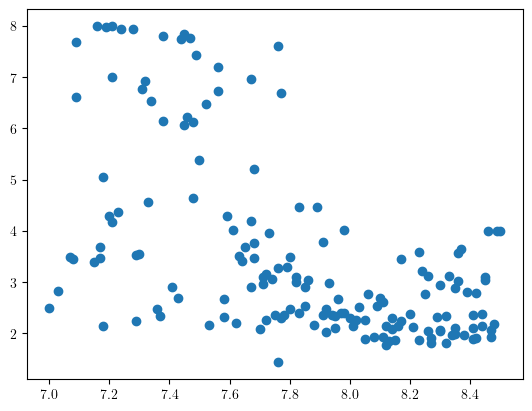

In [11]:
indsel = np.where(params_all[:,0] != 8.0)[0]
pl.figure()
pl.plot(np.array(dT_all)[indsel], params_all[:,0][indsel], 'o')
# pl.plot(params_all[:,0], 'o')


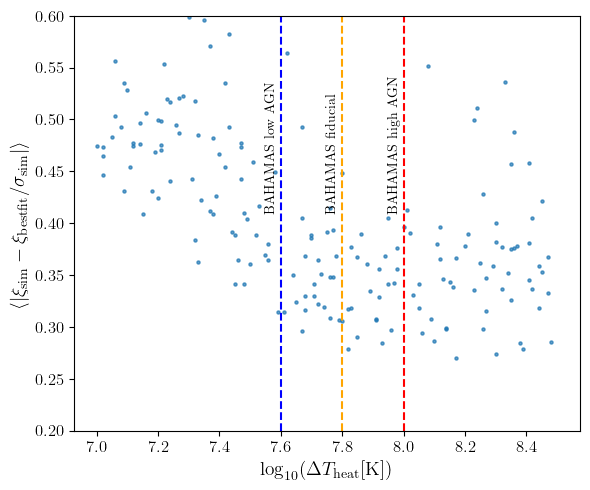

In [12]:
# dT_all
pl.figure(figsize=(6,5))
pl.scatter(dT_all, mean_err_sigma_all, alpha=0.7, s=5)
pl.xlabel(r'$\log_{10}(\Delta T_{\rm heat}[{\rm K}])$', fontsize=14)
pl.ylabel(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\sigma_{\rm sim}| \rangle$', fontsize=14)
pl.axvline(7.6, color='b', ls='--')
pl.ylim(0.2, 0.6)
pl.text(7.55, 0.41, r'BAHAMAS low AGN', rotation=90, fontsize=10)
pl.axvline(7.8, color='orange', ls='--')
pl.text(7.75, 0.41, r'BAHAMAS fiducial', rotation=90, fontsize=10)
pl.axvline(8.0, color='r', ls='--')
pl.text(7.95, 0.41, r'BAHAMAS high AGN', rotation=90, fontsize=10)
# set the tick label sizes:
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
# pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/BCMP_18_wP_fit_mean_err_sigma_vs_dT_FINALSET.pdf',bbox_inches='tight')




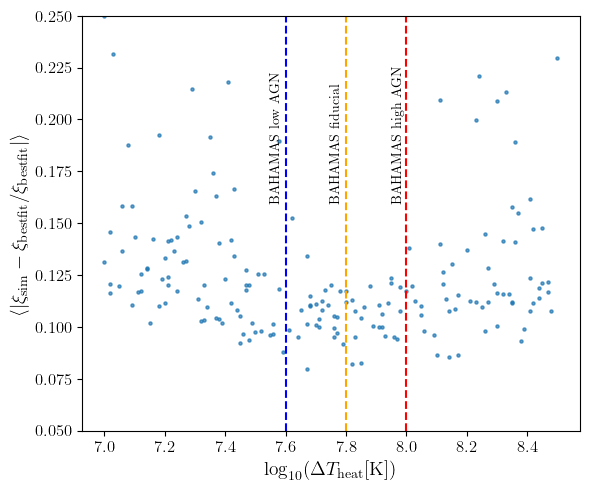

In [13]:
# dT_all
pl.figure(figsize=(6,5))
pl.scatter(dT_all, mean_err_all, alpha=0.7, s=5)
pl.xlabel(r'$\log_{10}(\Delta T_{\rm heat}[{\rm K}])$', fontsize=14)
pl.ylabel(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\xi_{\rm bestfit}| \rangle$', fontsize=14)
pl.axvline(7.6, color='b', ls='--')
pl.text(7.55, 0.16, r'BAHAMAS low AGN', rotation=90, fontsize=10)
pl.axvline(7.8, color='orange', ls='--')
pl.text(7.75, 0.16, r'BAHAMAS fiducial', rotation=90, fontsize=10)
pl.axvline(8.0, color='r', ls='--')
pl.text(7.95, 0.16, r'BAHAMAS high AGN', rotation=90, fontsize=10)
pl.ylim(0.05, 0.25)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
# pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/BCMP_18_wP_fit_mean_err_vs_dT_FINALSET.pdf',bbox_inches='tight')




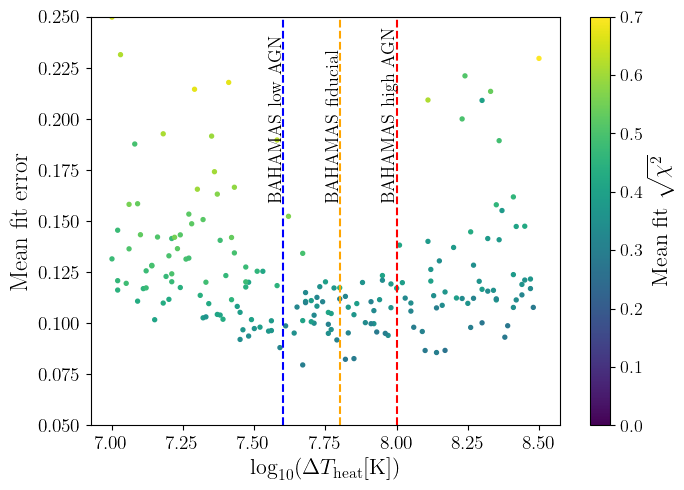

In [17]:
# dT_all
pl.figure(figsize=(7,5))
# pl.scatter(dT_all, mean_err_all, alpha=0.7, s=5)
# color each point by the mean_err_sigma:
vmin, vmax = 0.0, 0.7
scatter = pl.scatter(dT_all, mean_err_all, alpha=1.0, s=8, c=mean_err_sigma_all, cmap='viridis', vmin=vmin, vmax=vmax)
# set the colorbar:
cbar = pl.colorbar(scatter)
# cbar.set_label(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\sigma_{\rm sim}| \rangle$', fontsize=16)
cbar.set_label(r'Mean fit $\sqrt{\chi^2}$', fontsize=16)
cbar.ax.tick_params(labelsize=13)
pl.xlabel(r'$\log_{10}(\Delta T_{\rm heat}[{\rm K}])$', fontsize=16)
# pl.ylabel(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\xi_{\rm bestfit}| \rangle$', fontsize=16)
pl.ylabel(r'Mean fit error', fontsize=18)
pl.axvline(7.6, color='b', ls='--')
pl.text(7.55, 0.16, r'BAHAMAS low AGN', rotation=90, fontsize=13)
pl.axvline(7.8, color='orange', ls='--')
pl.text(7.75, 0.16, r'BAHAMAS fiducial', rotation=90, fontsize=13)
pl.axvline(8.0, color='r', ls='--')
pl.text(7.95, 0.16, r'BAHAMAS high AGN', rotation=90, fontsize=13)
pl.ylim(0.05, 0.25)
pl.tick_params(axis='both', which='major', labelsize=14)
pl.tick_params(axis='both', which='minor', labelsize=14)
pl.tight_layout()
pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/BCMP_18_wP_fit_mean_err_vs_dT_FINALSET2.pdf',bbox_inches='tight')






(0.05, 0.25)

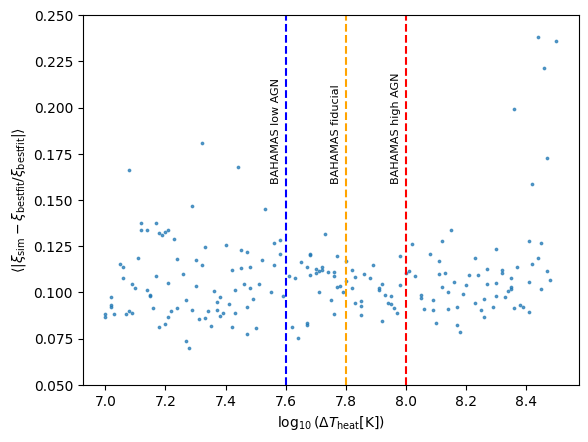

In [11]:
pl.figure()
pl.scatter(dT_all, mean_err_all, alpha=0.7, s=3)
pl.xlabel(r'$\log_{10}(\Delta T_{\rm heat}[{\rm K}])$')
pl.ylabel(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\xi_{\rm bestfit}| \rangle$')
pl.axvline(7.6, color='b', ls='--')
pl.text(7.55, 0.16, r'BAHAMAS low AGN', rotation=90, fontsize=8)
pl.axvline(7.8, color='orange', ls='--')
pl.text(7.75, 0.16, r'BAHAMAS fiducial', rotation=90, fontsize=8)
pl.axvline(8.0, color='r', ls='--')
pl.text(7.95, 0.16, r'BAHAMAS high AGN', rotation=90, fontsize=8)
pl.ylim(0.05, 0.25)


In [9]:
# saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams.pkl','rb'))
saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_FINALSET_windiv_error.pkl','rb'))
mean_err_all = []
mean_err_sigma_all = []
keys_all = []
params_all = np.zeros((len(saved_plot_data_all.keys()), len(saved_plot_data_all[list(saved_plot_data_all.keys())[0]]['params_bestfit'])))
for jsim in range(len(all_sims_names)):
    try:
        mean_err = saved_plot_data_all[all_sims_names[jsim]]['mean_err']
        mean_err_sigma = saved_plot_data_all[all_sims_names[jsim]]['mean_err_sigma']
        keys_all.append(all_sims_names[jsim])
        mean_err_all.append(mean_err)
        mean_err_sigma_all.append(mean_err_sigma)
        params_all[jsim,:] = saved_plot_data_all[all_sims_names[jsim]]['params_bestfit']
    except:
        pass

all_sims_names = keys_all


In [10]:
import re

def extract_specific_values(input_string):
    values = {}
    patterns = {
        'ws': r'ws_([0-9]+_[0-9]+)',
        'mu': r'mu_([0-9]+_[0-9]+)',
        'dT': r'dT_([0-9]+_[0-9]+)',
        'n': r'n_([0-9]+)',
        'BH_DensTh_m': r'BH_DensTh_m_([0-9]+_[0-9]+)'
    }
    for key, pattern in patterns.items():
        match = re.search(pattern, input_string)
        if match:
            number_str = match.group(1).replace('_', '.')
            values[key] = float(number_str)
    values['BH_DensTh_m'] = -1.*values['BH_DensTh_m']
    return values





In [11]:
dT_all = []
ws_all = []
mu_all = []
n_all = []
BH_DensTh_m_all = []
for jsim in range(len(all_sims_names)):
# for jsim in range(len(keys_all)):    
    # input_string = keys_all[jsim]
    input_string = all_sims_names[jsim]    
    extracted_values = extract_specific_values(input_string)
    dT_all.append(extracted_values['dT'])
    ws_all.append(extracted_values['ws'])
    mu_all.append(extracted_values['mu'])
    n_all.append(extracted_values['n'])
    BH_DensTh_m_all.append(extracted_values['BH_DensTh_m'])
    # print(extracted_values)
    # print(input_string)
    # print(extracted_values['ws'], extracted_values['mu'], extracted_values['dT'], extracted_values['n'], extracted_values['BH_DensTh_m'])
# input_string = "ws_55_04_mu_6_90_dT_7_80_n_1_BH_DensTh_m_2_24"
# extracted_values = extract_specific_values(input_string)
# print(extracted_values)



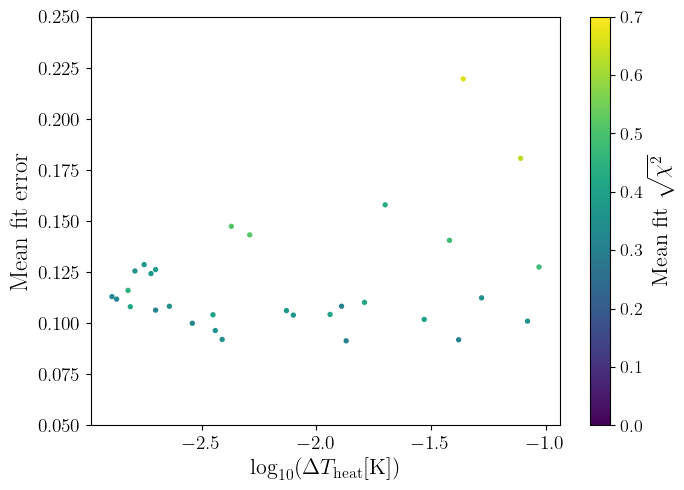

In [15]:
# dT_all
pl.figure(figsize=(7,5))
# pl.scatter(dT_all, mean_err_all, alpha=0.7, s=5)
# color each point by the mean_err_sigma:
vmin, vmax = 0.0, 0.7
scatter = pl.scatter(BH_DensTh_m_all, mean_err_all, alpha=1.0, s=8, c=mean_err_sigma_all, cmap='viridis', vmin=vmin, vmax=vmax)
# set the colorbar:
cbar = pl.colorbar(scatter)
# cbar.set_label(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\sigma_{\rm sim}| \rangle$', fontsize=16)
cbar.set_label(r'Mean fit $\sqrt{\chi^2}$', fontsize=16)
cbar.ax.tick_params(labelsize=13)
pl.xlabel(r'$\log_{10}(\Delta T_{\rm heat}[{\rm K}])$', fontsize=16)
# pl.ylabel(r'$\langle |\xi_{\rm sim} - \xi_{\rm bestfit}/\xi_{\rm bestfit}| \rangle$', fontsize=16)
pl.ylabel(r'Mean fit error', fontsize=18)
# pl.axvline(7.6, color='b', ls='--')
# pl.text(7.55, 0.16, r'BAHAMAS low AGN', rotation=90, fontsize=13)
# pl.axvline(7.8, color='orange', ls='--')
# pl.text(7.75, 0.16, r'BAHAMAS fiducial', rotation=90, fontsize=13)
# pl.axvline(8.0, color='r', ls='--')
# pl.text(7.95, 0.16, r'BAHAMAS high AGN', rotation=90, fontsize=13)
pl.ylim(0.05, 0.25)
pl.tick_params(axis='both', which='major', labelsize=14)
pl.tick_params(axis='both', which='minor', labelsize=14)
pl.tight_layout()
# pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/BCMP_18_wP_fit_mean_err_vs_dT_FINALSET2.pdf',bbox_inches='tight')




